In [19]:
import numpy as np
import matplotlib.pylab as plt
from collections import Counter
import json
import gc
from gensim.models import Word2Vec
import annoy # fast approximate KNN
%matplotlib inline

In [8]:
!head UP000002311.goByGeneC

gene seq annot
"P32317" "MIALKPNAVRTFRQVQHCSFRICRYQSTKSNKCLTPLQEYDRLVKLGKLRDDTYQRGIISSLGDLYDSLVKYVPPVVKTPNAVDQVGGWLNGLKSVFSRGKPKNIGAYVDVSKIGNSIPRGVYLYGDVGCGKTMLMDLFYTTIPNHLTKKRIHFHQFMQYVHKRSHEIVREQNLKELGDAKGKEIDTVPFLAAEIANNSHVLCFDEFQVTDVADAMILRRLMTALLSDDYGVVLFATSNRHPDELYINGVQRQSFIPCIELIKHRTKVIFLNSPTDYRKIPRPVSSVYYFPSDTSIKYASKECKTRRETHIKEWYNYFAQASHTDDSTDSHTVHKTFYDYPLTIWGREFKVPKCTPPRVAQFTFKQLCGEPLAAGDYLTLAKNFEAFIVTDIPYLSIYVRDEVRRFITFLDAVYDSGGKLATTGAADFSSLFVEPEQILNDFELRPTTKEPDSVDTGMVDEMVEKHGFSKEIAKKSQMFALDEERFAFARALSRLSQMSSTDWVTKPTY" "GO:0005575, GO:0005622, GO:0005623, GO:0005737, GO:0005739, GO:0043226, GO:0043227, GO:0043229, GO:0043231, GO:0044424, GO:0044444, GO:0044464"
"P87275" "MIEEKKELKKRRVLQMARFYGAAAFTLITMRLISRAIKVRKYVPSIFQQNYKLPPFSQRNEAMSALTYASAASIGTFSTLIFGFCWALDISTAREFVFKTREFMSLPQALETDTSMDEETSKLTKQLQDLLSSENNK" "GO:0005575, GO:0005622, GO:0005623, GO:0005737, GO:0005739, GO:0043226, GO:0043227, GO:0043229, GO:0043231, GO:0044424, GO:0044444, GO:0044464"
"P39010" "MVNELENVPRASTLT

In [10]:
X = [] # sequence strings
Y = [] # list of labels for each sequence

with open('./UP000002311.goByGeneC') as inp:
    inp.readline() # header
    for line in inp:
        tokens = list(map(lambda x: x.strip('"'), line.split(' ',2)))
        X.append(tokens[1])
        Y.append([t.strip().strip('"') for t in tokens[2].split(',') if len(t.strip())>0])
        

In [11]:
all_y_list = []
for ys in Y:
    all_y_list.extend(ys)

In [12]:
counter = Counter(all_y_list)

(0, 20)

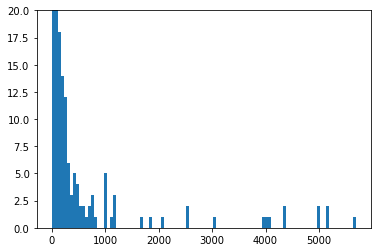

In [13]:
plt.hist(counter.values(), bins=100)
plt.ylim((0,20))

(0, 500)

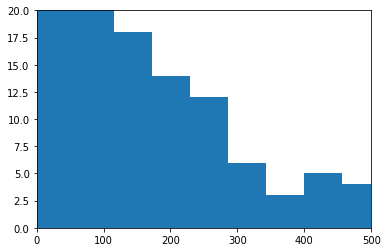

In [15]:
plt.hist(counter.values(), bins=100)
plt.ylim((0,20))
plt.xlim(0,500)

In [16]:
good_labels = set()
for y in all_y_list:
    if counter[y]>100 and counter[y]<=2500:
        good_labels.add(y)

In [18]:
len(good_labels), len(set(all_y_list))

(101, 1043)

In [20]:
X = [] # sequence strings
Y = [] # list of labels for each sequence
all_y = set() # all the labels collected from the dataset
with open('./UP000002311.goByGeneC') as inp:
    inp.readline() # header
    for line in inp:
        tokens = map(lambda x: x.strip('"'), line.split(' ',2))
        X.append(tokens[1])
        object_labels = [t.strip().strip('"') for t in tokens[2].split(',') if len(t.strip())>0 and t.strip]
        Y.append([y for y in object_labels if y in good_labels])
        all_y = all_y.union(set(Y[-1]))

In [21]:
print 'example of X', X[:3]
print 'example of Y', Y[:3]
print 'example of set of labels', list(all_y)[:3]
print 'total sequences', len(X)
print 'total labels', len(all_y)

example of X ['MIALKPNAVRTFRQVQHCSFRICRYQSTKSNKCLTPLQEYDRLVKLGKLRDDTYQRGIISSLGDLYDSLVKYVPPVVKTPNAVDQVGGWLNGLKSVFSRGKPKNIGAYVDVSKIGNSIPRGVYLYGDVGCGKTMLMDLFYTTIPNHLTKKRIHFHQFMQYVHKRSHEIVREQNLKELGDAKGKEIDTVPFLAAEIANNSHVLCFDEFQVTDVADAMILRRLMTALLSDDYGVVLFATSNRHPDELYINGVQRQSFIPCIELIKHRTKVIFLNSPTDYRKIPRPVSSVYYFPSDTSIKYASKECKTRRETHIKEWYNYFAQASHTDDSTDSHTVHKTFYDYPLTIWGREFKVPKCTPPRVAQFTFKQLCGEPLAAGDYLTLAKNFEAFIVTDIPYLSIYVRDEVRRFITFLDAVYDSGGKLATTGAADFSSLFVEPEQILNDFELRPTTKEPDSVDTGMVDEMVEKHGFSKEIAKKSQMFALDEERFAFARALSRLSQMSSTDWVTKPTY', 'MIEEKKELKKRRVLQMARFYGAAAFTLITMRLISRAIKVRKYVPSIFQQNYKLPPFSQRNEAMSALTYASAASIGTFSTLIFGFCWALDISTAREFVFKTREFMSLPQALETDTSMDEETSKLTKQLQDLLSSENNK', 'MVNELENVPRASTLTNEEQTVDPSNNDSQEDISLGDSNEITSLASLKAIRSGNEEESGNEQVNHNDEAEEDPLLTRYHTACQRGDLATVKEMIHGKLLEVNNDGDSTEHITGLHWASINNRLSVVDFLVSQGADVNARAGALHATPLHWAARYGYVYIVDFLLKHGADPTMTDDQGFNLLHLSVNSSNIMLVLYVLFNVVSKGLLDIDCRDPKGRTSLLWAAYQGDSLTVAELLKFGASIKIADTEGFTPLHWGTVKGQPHVLKYLIQDGADFFQKTDTGKDCFAIAQEMNTVYSLREALTHSGFDYHGYPIKKWFKKSQHAKLVTFITPF

In [22]:
def cv_iter(w2v_params):    
    """
    one ieration of cross-validation
    w2v_params is a dictionary with parameters of gensim.Word2Vec
    """
    indices = range(len(X))
    np.random.shuffle(indices)

    Xtrain = np.array(X)[indices[:len(indices)/2]]
    Ytrain = np.array(Y)[indices[:len(indices)/2]]
    Xtest = np.array(X)[indices[len(indices)/2:]]
    Ytest = np.array(Y)[indices[len(indices)/2:]]
    # split all the strings into lists for word2vec traing
    Xtrain = [list(x) for x in Xtrain]
    Xtest = [list(x) for x in Xtest]
    model = Word2Vec(Xtrain, **w2v_params)
    index = annoy.AnnoyIndex(w2v_params.get('size', 100)) # default value is 100 for gensim.Word2Vec
    for i in range(len(Xtrain)):
        v= np.mean([model[c] for c in Xtrain[i]], axis=0) # centroid
        index.add_item(i, v)
    index.build(100) # 100 is a number of trees in index, we can alibrate this value
    predicted = []
    for i in range(len(Xtest)):
        v= np.mean([model[c] for c in Xtest[i]], axis=0)
        id = index.get_nns_by_vector(v,1)[0] #  finding 1 nearest neighbour
        predicted.append(id)
    tp = 0
    fp = 0
    true_label_num = 0
    for i in xrange(len(Xtest)):
        true = set(Ytest[i])
        true_label_num+=len(true)
        pred = set(Ytrain[predicted[i]])
        tp += len(true&pred)
        fp += len(pred) - len(true&pred)

    prec=tp*1.0/(tp+fp)
    rec = tp*1.0/true_label_num
    return prec, rec,  2 * prec * rec/ (prec+rec)
    

In [23]:
def cv(w2v_params = {}, cv_num = 5 ):
    """
    Cross-validation function.
    Returns list with precision, recall and F1 values
    """
    precs, recs, fs = [],[],[]
    for _ in range(cv_num):
        p,r,f = cv_iter(w2v_params)
        precs.append(p)
        recs.append(r)
        fs.append(f)
    return precs, recs, fs

In [24]:
p,r,f = cv()
np.mean(p), np.mean(r), np.mean(f)

(0.2661944645861868, 0.26621071467210394, 0.26613001528921787)

In [25]:
p,r,f = cv({'size':5})
np.mean(p), np.mean(r), np.mean(f)

(0.21987112719228663, 0.2176892802094678, 0.2187269139267228)